In [1]:
# !pip install shap

In [1]:
import pandas as pd
import numpy as np
import random
import os
import math
from tqdm import tqdm

import matplotlib
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, accuracy_score

/home/user/anaconda3/envs/bsh/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Utils & preprocess

X = (batch, sequence, dimension)<br>
dimension은 feature 수 , sequence는 timestamp

y = (0,1) <br>
0 = healthy, 1 = failure

In [2]:
def extract_sequences(df, sequence_length, stride = 1 , next_time = True ):
    data_x = []
    assign_nums = df['배정번호'].unique()
    for assign_num in tqdm(assign_nums, total=len(assign_nums), desc='배정번호 별로 추출하는중'):
        sampled_labeled_df = df[df['배정번호']==assign_num]
        sampled_labeled_df = sampled_labeled_df.reset_index(drop=True)
        start_idx = 0
        while start_idx + sequence_length <= len(sampled_labeled_df):
            end_idx = start_idx + sequence_length
            sub_df = sampled_labeled_df.iloc[start_idx:end_idx]
            time_diff = (sub_df['TAG_MIN'].max() - sub_df['TAG_MIN'].min()).seconds
            if time_diff == sequence_length - 1:
                sequence = sub_df.drop(columns=['TAG_MIN', '배정번호','불량여부']).values
                data_x.append(sequence)
                if next_time == True:
                    start_idx = end_idx
                else:
                    start_idx += stride
            else:
                start_idx += stride
    return np.stack(data_x, axis=0)

In [3]:
def make_dataset(data , quality, threshold = 0.1, sequence_length = 60, downsampling = 2000):

    quality['불량률'] = quality['불량수량']/ quality['총수량'] * 100
    quality['불량여부'] = quality['불량률'].apply(lambda x: 1 if x > threshold else 0)
    labeled_df = data.merge(quality[['배정번호','불량여부']], on='배정번호', how='left')
    labeled_df['TAG_MIN'] =pd.to_datetime(labeled_df.TAG_MIN, format='%Y-%m-%d %H:%M:%S')
    labeled_df = labeled_df.dropna() # 지금은 결측치가 있는 행을 제거
    labeled_df_healthy = labeled_df[labeled_df['불량여부']==0]
    labeled_df_failure = labeled_df[labeled_df['불량여부']==1]
    healthy_x = extract_sequences(labeled_df_healthy, sequence_length , stride = 1, next_time = True)
    failure_x = extract_sequences(labeled_df_failure, sequence_length , stride = 1, next_time = True)
    random_indices = np.random.choice(healthy_x.shape[0], downsampling, replace=False)
    healthy_x = healthy_x[random_indices]
    healthy_y = np.zeros(len(healthy_x))
    failure_y = np.ones(len(failure_x))
    x_data = np.concatenate((healthy_x, failure_x), axis=0)
    y_data = np.concatenate((healthy_y, failure_y), axis=0)
    x_data, y_data = shuffle(x_data, y_data, random_state=42)
    return x_data, y_data

In [4]:
def Scaler_split(x_data, y_data,sequence_length = 60):

    number = list(range(1, len(x_data)))
    random.shuffle(number)
    train_ratio = 0.6
    valid_ratio = 0.2

    total_len = len(x_data)
    train_len = int(total_len * train_ratio)
    valid_len = int(total_len * valid_ratio)

    train_num = number[:train_len]
    valid_num = number[train_len:train_len+valid_len]
    test_num = number[train_len+valid_len:]

    X_train = x_data[train_num].reshape((-1,19))
    X_valid = x_data[valid_num].reshape((-1,19))
    X_test = x_data[test_num].reshape((-1,19))

    y_train = y_data[train_num]
    y_valid = y_data[valid_num]
    y_test = y_data[test_num]

    scaler = StandardScaler()
    scaler.fit(X_train)

    X_train = scaler.transform(X_train).reshape((-1,sequence_length,19))
    X_valid = scaler.transform(X_valid).reshape((-1,sequence_length,19))
    X_test = scaler.transform(X_test).reshape((-1,sequence_length,19))

    return X_train, X_valid, X_test, y_train, y_valid, y_test

In [5]:
class MyDataset(Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = torch.tensor(x_data, dtype=torch.float32)
        self.y_data = torch.tensor(y_data, dtype=torch.float32)

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        return self.x_data[idx], self.y_data[idx]

In [6]:
def plot_losses(train_losses, valid_losses, epochs):
    plt.figure(figsize=(5, 3))

    # epochs가 int 타입이라면 range로 리스트 생성
    if isinstance(epochs, int):
        epochs = list(range(1, epochs+1))

    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, valid_losses, label='Validation Loss')
    plt.title('Train and Validation Losses over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [7]:
def plot_accuracies(train_accuracies, valid_accuracies, epochs):
    plt.figure(figsize=(5, 3))

    # epochs가 int 타입이라면 range로 리스트 생성
    if isinstance(epochs, int):
        epochs = list(range(1, epochs+1))

    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, valid_accuracies, label='Validation Accuracy')
    plt.title('Train and Validation Accuracies over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [8]:
def test(model, test_loader):
    model.eval()

    all_labels = []
    all_probabilities = []

    with torch.no_grad():
        for batch in tqdm(test_loader):
            x_data_batch, y_data_batch = batch

            x_data_batch = x_data_batch.to(device)
            y_data_batch = y_data_batch.to(device)

            probabilities = model(x_data_batch)[:, 1]
            all_probabilities.extend(probabilities.cpu().numpy())
            all_labels.extend(y_data_batch.cpu().numpy())

    all_predictions = [1 if prob > 0.5 else 0 for prob in all_probabilities]

    f1 = f1_score(all_labels, all_predictions, average='macro')
    auroc = roc_auc_score(all_labels, all_probabilities)
    accuracy = accuracy_score(all_labels, all_predictions)

    return f1, auroc, accuracy, all_labels, all_probabilities

In [9]:
def plot_roc_curve(y_true, y_score):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    plt.plot(fpr, tpr, linestyle='-', label='Model')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

# Model

In [10]:
class LSTM(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.hidden_size = config.hidden_size
        self.lstm = nn.LSTM(config.input_size, config.hidden_size, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(config.hidden_size, config.hidden_size//2),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(config.hidden_size//2, config.output_size)
        )
        self.actv = nn.ReLU()

    def forward(self, x):
        batch_size = x.size(0)
        hidden = self.init_hidden(batch_size, x.device)
        lstm_out, hidden = self.lstm(x, hidden)
        last_output = lstm_out[:, -1, :]
        output = self.actv(self.fc(last_output))

        return output.squeeze(1)

    def init_hidden(self, batch_size, device):
        return (torch.zeros(1, batch_size, self.hidden_size, device=device),
                torch.zeros(1, batch_size, self.hidden_size, device=device))

# trainer 구현

In [11]:
class Trainer():
  def __init__(self, model, optimizer, loss_function, device):
    super().__init__()
    self.model = model
    self.optimizer = optimizer
    self.loss_function = loss_function
    self.device = device

  def train(self, train_loader, config):
    self.model.train()

    total_loss = 0
    total_correct = 0

    batch_size = train_loader.batch_size
    total_dataset_size = len(train_loader.dataset)
    num_batches = math.ceil(total_dataset_size / batch_size)

    for batch in tqdm( train_loader, total = num_batches ):
      self.optimizer.zero_grad()

      x_data_batch, y_data_batch = batch

      x_data_batch = x_data_batch.to(self.device)
      y_data_batch = y_data_batch.to(self.device)

      outputs = self.model(x_data_batch)
      loss = self.loss_function(outputs, y_data_batch.long())
      total_loss += loss.item()

      #역전파
      loss.backward()
      self.optimizer.step()

      _, predicted = torch.max(outputs, 1)  # 확률이 가장 높은 클래스를 선택
      correct = (predicted == y_data_batch).sum().item()
      total_correct += correct

    avg_loss = total_loss / total_dataset_size
    accuracy = total_correct / total_dataset_size

    return avg_loss, accuracy

  def valid(self, valid_loader, config):
    self.model.eval()  # 모델을 평가 모드로 전환

    total_loss = 0
    total_correct = 0

    batch_size = valid_loader.batch_size
    total_dataset_size = len(valid_loader.dataset)
    num_batches = math.ceil(total_dataset_size / batch_size)

    with torch.no_grad():  # 그래디언트 계산을 비활성화
        for batch in tqdm(valid_loader, total=num_batches):
            x_data_batch, y_data_batch = batch

            x_data_batch = x_data_batch.to(self.device)
            y_data_batch = y_data_batch.to(self.device)

            outputs = self.model(x_data_batch)
            loss = self.loss_function(outputs, y_data_batch.long())
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)  # 확률이 가장 높은 클래스를 선택
            correct = (predicted == y_data_batch).sum().item()
            total_correct += correct

    avg_loss = total_loss / total_dataset_size
    accuracy = total_correct / total_dataset_size

    return avg_loss, accuracy

  def test(self, test_loader, config):
    self.model.eval()  # 모델을 평가 모드로 전환

    total_loss = 0
    total_correct = 0

    batch_size = test_loader.batch_size
    total_dataset_size = len(test_loader.dataset)
    num_batches = math.ceil(total_dataset_size / batch_size)

    with torch.no_grad():  # 그래디언트 계산을 비활성화
        for batch in tqdm(test_loader, total=num_batches):
            x_data_batch, y_data_batch = batch

            x_data_batch = x_data_batch.to(self.device)
            y_data_batch = y_data_batch.to(self.device)

            outputs = self.model(x_data_batch)
            loss = self.loss_function(outputs, y_data_batch.long())
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)  # 확률이 가장 높은 클래스를 선택
            correct = (predicted == y_data_batch).sum().item()
            total_correct += correct

    avg_loss = total_loss / total_dataset_size
    accuracy = total_correct / total_dataset_size

    return avg_loss, accuracy

  def save_model(self, epoch, path="model_checkpoint"):
    model_path = f"{path}_epoch_{epoch}.pth"
    torch.save(self.model.state_dict(), model_path)
    print(f"Model saved")
    
  def save_best_model(self, path="model_checkpoint"):
    model_path = f"{path}_best_model.pth"
    torch.save(self.model.state_dict(), model_path)
    print(f"Model saved")

# Main

In [12]:
class Config():
  threshold = 0.1        # 불량률을 몇 퍼센트까지 0.1로 정의할 것인지
  sequence_length = 60   # 몇초를 하나의 instance로 볼 것인지
  downsampling = 3000    # healthy data를 몇개를 쓸지
  EPOCH = 200
  LEARNING_RATE = 0.001
  BATCH_SIZE = 256
  SEED = 42
  input_size = 19        # 처음 input의 차원의 개수 (feature수와 같다)
  hidden_size=512        # LSTM hidden vector size
  output_size = 2        # output 차원의 개수

config = Config()

In [13]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(config.SEED) # Seed 고정

In [14]:
df = pd.read_csv('/home/user/Desktop/bsh/absoluteA/data/data.csv',encoding = 'cp949')
quality = pd.read_excel('/home/user/Desktop/bsh/absoluteA/data/quality.xlsx')

In [15]:
# 정의한 기준에 맞게 label하고 정해준 시간만큼 split하고 dataset만들기
x_data, y_data = make_dataset(df,quality , threshold = config.threshold, sequence_length = config.sequence_length, downsampling = config.downsampling )

배정번호 별로 추출하는중: 100%|██████████| 7/7 [00:03<00:00,  1.87it/s]


In [16]:
print('healthy(0)의 개수 :',int(len(y_data)-y_data.sum()))
print('failure(1)의 개수 :',int(y_data.sum()))

healthy(0)의 개수 : 3000
failure(1)의 개수 : 1569


In [17]:
X_train, X_valid, X_test, y_train, y_valid, y_test = Scaler_split(x_data, y_data, sequence_length = config.sequence_length)

In [18]:
# 인스턴스 생성
train_dataset = MyDataset(X_train, y_train)
valid_dataset = MyDataset(X_valid, y_valid)
test_dataset = MyDataset(X_test, y_test)

del X_train, X_valid, X_test, y_train, y_valid, y_test

In [19]:
# batch로 분할
train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=config.BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=config.BATCH_SIZE, shuffle=True)

In [20]:
#데이터 수 확인
total_train_data = len(train_loader.dataset)
print(f"Total number of data samples in train_loader: {total_train_data}")
total_valid_data = len(valid_loader.dataset)
print(f"Total number of data samples in valid_loader: {total_valid_data}")
total_test_data = len(test_loader.dataset)
print(f"Total number of data samples in test_loader: {total_test_data}")

Total number of data samples in train_loader: 2741
Total number of data samples in valid_loader: 913
Total number of data samples in test_loader: 914


In [21]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [22]:
# model, optimizer, loss_function 구현하고 결합시키기
model = LSTM(config)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=config.LEARNING_RATE)
loss_function = nn.CrossEntropyLoss()
trainer = Trainer(model, optimizer, loss_function, device)

In [23]:
# save path 지정 잘해줄 것!!!!!!!!(일단 지금은 저장하지 말자)
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []
valid_accuracy_save = 0
best_epoch_save = 0 

for epoch in range(config.EPOCH):
    print('=====================================================================================')
    print("epoch {}".format(epoch+1))

    train_loss, train_accuracy = trainer.train(train_loader, config)
    valid_loss, valid_accuracy = trainer.valid(valid_loader, config)
    if valid_accuracy_save < valid_accuracy :
      trainer.save_best_model(path = '/home/user/Desktop/bsh/absoluteA/model/3000_LSTM') # 이 부분!!!!
      valid_accuracy_save = valid_accuracy
      best_epoch_save = epoch + 1

    # 결과값을 리스트에 추가
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accuracies.append(train_accuracy)
    valid_accuracies.append(valid_accuracy)

    print("TRAIN LOSS = {}, TRAIN ACC = {}, ".format(train_loss, train_accuracy))
    print("VALID LOSS = {}, VALID ACC = {}, ".format(valid_loss, valid_accuracy))

epoch 1


100%|██████████| 4/4 [00:00<00:00, 536.00it/s]


Model saved
TRAIN LOSS = 0.0024754564851707283, TRAIN ACC = 0.6993797883983948, 
VALID LOSS = 0.0025519513222108403, VALID ACC = 0.7119386637458927, 
epoch 2


100%|██████████| 4/4 [00:00<00:00, 539.13it/s]


Model saved
TRAIN LOSS = 0.002197325186153608, TRAIN ACC = 0.7351331630791682, 
VALID LOSS = 0.0024805896122902142, VALID ACC = 0.7152245345016429, 
epoch 3


100%|██████████| 4/4 [00:00<00:00, 499.56it/s]


Model saved
TRAIN LOSS = 0.002122388426207661, TRAIN ACC = 0.7479022254651587, 
VALID LOSS = 0.002360437224493622, VALID ACC = 0.7404162102957283, 
epoch 4


100%|██████████| 4/4 [00:00<00:00, 518.84it/s]


Model saved
TRAIN LOSS = 0.002093067920716824, TRAIN ACC = 0.7566581539584093, 
VALID LOSS = 0.0023163106590346205, VALID ACC = 0.7502738225629791, 
epoch 5


100%|██████████| 4/4 [00:00<00:00, 537.97it/s]


TRAIN LOSS = 0.001999488487073167, TRAIN ACC = 0.7661437431594309, 
VALID LOSS = 0.002303239484475711, VALID ACC = 0.7469879518072289, 
epoch 6


100%|██████████| 4/4 [00:00<00:00, 529.25it/s]


Model saved
TRAIN LOSS = 0.0018805980421426043, TRAIN ACC = 0.768697555636629, 
VALID LOSS = 0.002083362030173445, VALID ACC = 0.755750273822563, 
epoch 7


100%|██████████| 4/4 [00:00<00:00, 549.60it/s]


Model saved
TRAIN LOSS = 0.0018861015340526015, TRAIN ACC = 0.777818314483765, 
VALID LOSS = 0.002111797395436683, VALID ACC = 0.7776560788608982, 
epoch 8


100%|██████████| 4/4 [00:00<00:00, 545.67it/s]


Model saved
TRAIN LOSS = 0.0017949078083908153, TRAIN ACC = 0.7931411893469537, 
VALID LOSS = 0.001953819462660239, VALID ACC = 0.787513691128149, 
epoch 9


100%|██████████| 4/4 [00:00<00:00, 553.87it/s]


TRAIN LOSS = 0.0018095483161462828, TRAIN ACC = 0.7690623859905145, 
VALID LOSS = 0.0020703062627297243, VALID ACC = 0.7524644030668127, 
epoch 10


100%|██████████| 4/4 [00:00<00:00, 551.81it/s]

TRAIN LOSS = 0.001797804961627263, TRAIN ACC = 0.7665085735133164, 
VALID LOSS = 0.001971849606567249, VALID ACC = 0.7623220153340635, 
epoch 11



100%|██████████| 4/4 [00:00<00:00, 549.77it/s]


TRAIN LOSS = 0.0016394602104244072, TRAIN ACC = 0.7938708500547246, 
VALID LOSS = 0.001885939564919028, VALID ACC = 0.755750273822563, 
epoch 12


100%|██████████| 4/4 [00:00<00:00, 523.58it/s]


TRAIN LOSS = 0.0015462076020301672, TRAIN ACC = 0.7938708500547246, 
VALID LOSS = 0.0016690094395247896, VALID ACC = 0.7864184008762322, 
epoch 13


100%|██████████| 4/4 [00:00<00:00, 513.39it/s]


TRAIN LOSS = 0.0014312338628981159, TRAIN ACC = 0.8011674571324334, 
VALID LOSS = 0.0016447451589924873, VALID ACC = 0.7842278203723987, 
epoch 14


100%|██████████| 4/4 [00:00<00:00, 524.73it/s]


Model saved
TRAIN LOSS = 0.0013297477785317144, TRAIN ACC = 0.826340751550529, 
VALID LOSS = 0.0016237287440409665, VALID ACC = 0.7951807228915663, 
epoch 15


100%|██████████| 4/4 [00:00<00:00, 497.29it/s]


TRAIN LOSS = 0.001498488723601098, TRAIN ACC = 0.8022619481940898, 
VALID LOSS = 0.0017979287696433094, VALID ACC = 0.7568455640744798, 
epoch 16


100%|██████████| 4/4 [00:00<00:00, 540.54it/s]


Model saved
TRAIN LOSS = 0.0014602390900444523, TRAIN ACC = 0.7986136446552353, 
VALID LOSS = 0.0017049899498186394, VALID ACC = 0.8116100766703176, 
epoch 17


100%|██████████| 4/4 [00:00<00:00, 533.85it/s]


TRAIN LOSS = 0.0014245936097301997, TRAIN ACC = 0.8113827070412258, 
VALID LOSS = 0.0018576292518979226, VALID ACC = 0.787513691128149, 
epoch 18


100%|██████████| 4/4 [00:00<00:00, 544.40it/s]


TRAIN LOSS = 0.001428423474540418, TRAIN ACC = 0.8201386355344765, 
VALID LOSS = 0.0016370674213731144, VALID ACC = 0.7798466593647316, 
epoch 19


100%|██████████| 4/4 [00:00<00:00, 550.42it/s]


TRAIN LOSS = 0.0013278029948766543, TRAIN ACC = 0.8215979569500182, 
VALID LOSS = 0.002016387822724642, VALID ACC = 0.7612267250821467, 
epoch 20


100%|██████████| 4/4 [00:00<00:00, 538.53it/s]


TRAIN LOSS = 0.001293544697961595, TRAIN ACC = 0.8205034658883619, 
VALID LOSS = 0.00179938033533253, VALID ACC = 0.7798466593647316, 
epoch 21


100%|██████████| 4/4 [00:00<00:00, 508.74it/s]


TRAIN LOSS = 0.001218724864018916, TRAIN ACC = 0.835461510397665, 
VALID LOSS = 0.0014741291809186486, VALID ACC = 0.8094194961664841, 
epoch 22


100%|██████████| 4/4 [00:00<00:00, 551.94it/s]


Model saved
TRAIN LOSS = 0.0011181378399355922, TRAIN ACC = 0.8416636264137176, 
VALID LOSS = 0.0016080248133898566, VALID ACC = 0.8225629791894852, 
epoch 23


100%|██████████| 4/4 [00:00<00:00, 550.85it/s]


Model saved
TRAIN LOSS = 0.0012527614973270732, TRAIN ACC = 0.838744983582634, 
VALID LOSS = 0.0014523032069336808, VALID ACC = 0.828039430449069, 
epoch 24


100%|██████████| 4/4 [00:00<00:00, 549.37it/s]


TRAIN LOSS = 0.0011632664388046348, TRAIN ACC = 0.8478657424297702, 
VALID LOSS = 0.0015570618301989085, VALID ACC = 0.823658269441402, 
epoch 25


100%|██████████| 4/4 [00:00<00:00, 555.91it/s]


Model saved
TRAIN LOSS = 0.0011530714731327768, TRAIN ACC = 0.8661072601240423, 
VALID LOSS = 0.0015000851431133191, VALID ACC = 0.8357064622124863, 
epoch 26


100%|██████████| 4/4 [00:00<00:00, 511.39it/s]


Model saved
TRAIN LOSS = 0.0011198275478944775, TRAIN ACC = 0.858445822692448, 
VALID LOSS = 0.0014375641795134361, VALID ACC = 0.836801752464403, 
epoch 27


100%|██████████| 4/4 [00:00<00:00, 550.83it/s]


TRAIN LOSS = 0.0010052636205954344, TRAIN ACC = 0.8766873403867201, 
VALID LOSS = 0.0015392685380457266, VALID ACC = 0.823658269441402, 
epoch 28


100%|██████████| 4/4 [00:00<00:00, 460.74it/s]


Model saved
TRAIN LOSS = 0.0009946447247703855, TRAIN ACC = 0.8865377599416271, 
VALID LOSS = 0.0014903075984900517, VALID ACC = 0.8433734939759037, 
epoch 29


100%|██████████| 4/4 [00:00<00:00, 545.76it/s]


TRAIN LOSS = 0.0010335618770718356, TRAIN ACC = 0.8792411528639182, 
VALID LOSS = 0.0013737932157673162, VALID ACC = 0.8433734939759037, 
epoch 30


100%|██████████| 4/4 [00:00<00:00, 543.00it/s]


Model saved
TRAIN LOSS = 0.000946483916281262, TRAIN ACC = 0.8923750456037942, 
VALID LOSS = 0.0014148126034982103, VALID ACC = 0.8488499452354874, 
epoch 31


100%|██████████| 4/4 [00:00<00:00, 523.55it/s]


Model saved
TRAIN LOSS = 0.0008576422255650701, TRAIN ACC = 0.900401313389274, 
VALID LOSS = 0.0015390543726161695, VALID ACC = 0.8554216867469879, 
epoch 32


100%|██████████| 4/4 [00:00<00:00, 545.90it/s]


Model saved
TRAIN LOSS = 0.0007849401233405886, TRAIN ACC = 0.9106165632980664, 
VALID LOSS = 0.0015481537756757955, VALID ACC = 0.8630887185104053, 
epoch 33


100%|██████████| 4/4 [00:00<00:00, 543.96it/s]


TRAIN LOSS = 0.0009568134110063499, TRAIN ACC = 0.8982123312659613, 
VALID LOSS = 0.001606377296614882, VALID ACC = 0.8444687842278203, 
epoch 34


100%|██████████| 4/4 [00:00<00:00, 554.18it/s]


TRAIN LOSS = 0.0009286198595152072, TRAIN ACC = 0.9011309740970449, 
VALID LOSS = 0.0015070440343541358, VALID ACC = 0.8532311062431545, 
epoch 35


100%|██████████| 4/4 [00:00<00:00, 546.52it/s]


TRAIN LOSS = 0.0008968054237090858, TRAIN ACC = 0.9076979204669828, 
VALID LOSS = 0.0014600147945073975, VALID ACC = 0.8630887185104053, 
epoch 36


100%|██████████| 4/4 [00:00<00:00, 549.41it/s]


TRAIN LOSS = 0.0008150345595898049, TRAIN ACC = 0.9120758847136081, 
VALID LOSS = 0.0013413411796680548, VALID ACC = 0.8521358159912377, 
epoch 37


100%|██████████| 4/4 [00:00<00:00, 549.46it/s]


TRAIN LOSS = 0.0008701253159121848, TRAIN ACC = 0.9033199562203575, 
VALID LOSS = 0.0014165820551858674, VALID ACC = 0.8543263964950711, 
epoch 38


100%|██████████| 4/4 [00:00<00:00, 544.54it/s]


Model saved
TRAIN LOSS = 0.0007841487906788962, TRAIN ACC = 0.9106165632980664, 
VALID LOSS = 0.0015004260908212483, VALID ACC = 0.8652792990142387, 
epoch 39


100%|██████████| 4/4 [00:00<00:00, 543.73it/s]


TRAIN LOSS = 0.0007239949883704897, TRAIN ACC = 0.9211966435607443, 
VALID LOSS = 0.001412560716516217, VALID ACC = 0.8630887185104053, 
epoch 40


100%|██████████| 4/4 [00:00<00:00, 546.90it/s]


Model saved
TRAIN LOSS = 0.0007593186394831683, TRAIN ACC = 0.925939438161255, 
VALID LOSS = 0.0012952323354217597, VALID ACC = 0.8838992332968236, 
epoch 41


100%|██████████| 4/4 [00:00<00:00, 543.57it/s]


TRAIN LOSS = 0.0007311669917317126, TRAIN ACC = 0.9273987595767967, 
VALID LOSS = 0.0013823810830173723, VALID ACC = 0.8762322015334063, 
epoch 42


100%|██████████| 4/4 [00:00<00:00, 547.61it/s]


TRAIN LOSS = 0.0007583194136054183, TRAIN ACC = 0.9230207953301715, 
VALID LOSS = 0.0014836911564980514, VALID ACC = 0.8773274917853231, 
epoch 43


100%|██████████| 4/4 [00:00<00:00, 499.95it/s]


TRAIN LOSS = 0.000820480268047657, TRAIN ACC = 0.9193724917913171, 
VALID LOSS = 0.0012876464202918464, VALID ACC = 0.8751369112814896, 
epoch 44


100%|██████████| 4/4 [00:00<00:00, 546.12it/s]


TRAIN LOSS = 0.0007147681578281629, TRAIN ACC = 0.9306822327617658, 
VALID LOSS = 0.0012502264219202582, VALID ACC = 0.8740416210295728, 
epoch 45


100%|██████████| 4/4 [00:00<00:00, 554.11it/s]


Model saved
TRAIN LOSS = 0.0006486486612293504, TRAIN ACC = 0.9339657059467348, 
VALID LOSS = 0.001218924582461538, VALID ACC = 0.8926615553121577, 
epoch 46


100%|██████████| 4/4 [00:00<00:00, 553.89it/s]


TRAIN LOSS = 0.0005823364416772716, TRAIN ACC = 0.9383436701933601, 
VALID LOSS = 0.0012557935969330788, VALID ACC = 0.882803943044907, 
epoch 47


100%|██████████| 4/4 [00:00<00:00, 544.10it/s]


TRAIN LOSS = 0.0005529486009866728, TRAIN ACC = 0.9474644290404962, 
VALID LOSS = 0.001488043307474644, VALID ACC = 0.8806133625410734, 
epoch 48


100%|██████████| 4/4 [00:00<00:00, 545.05it/s]


TRAIN LOSS = 0.0005408508967457353, TRAIN ACC = 0.9503830718715797, 
VALID LOSS = 0.0014503158522853454, VALID ACC = 0.872946330777656, 
epoch 49


100%|██████████| 4/4 [00:00<00:00, 537.59it/s]


TRAIN LOSS = 0.0005173462258556037, TRAIN ACC = 0.9507479022254651, 
VALID LOSS = 0.0012328381704213454, VALID ACC = 0.891566265060241, 
epoch 50


100%|██████████| 4/4 [00:00<00:00, 545.65it/s]


TRAIN LOSS = 0.0004325128958547955, TRAIN ACC = 0.9598686610726013, 
VALID LOSS = 0.0012677121593291502, VALID ACC = 0.8926615553121577, 
epoch 51


100%|██████████| 4/4 [00:00<00:00, 535.30it/s]


Model saved
TRAIN LOSS = 0.00038632238946314146, TRAIN ACC = 0.9657059467347683, 
VALID LOSS = 0.0013447468539318406, VALID ACC = 0.8970427163198248, 
epoch 52


100%|██████████| 4/4 [00:00<00:00, 325.56it/s]


TRAIN LOSS = 0.0004781231893017883, TRAIN ACC = 0.9525720539948924, 
VALID LOSS = 0.0015412374824970993, VALID ACC = 0.8838992332968236, 
epoch 53


100%|██████████| 4/4 [00:00<00:00, 422.57it/s]


TRAIN LOSS = 0.00045544682943834, TRAIN ACC = 0.952207223641007, 
VALID LOSS = 0.0014833751800679168, VALID ACC = 0.8838992332968236, 
epoch 54


100%|██████████| 4/4 [00:00<00:00, 555.83it/s]


TRAIN LOSS = 0.0004978939450513443, TRAIN ACC = 0.9529368843487778, 
VALID LOSS = 0.001507825423174855, VALID ACC = 0.8882803943044907, 
epoch 55


100%|██████████| 4/4 [00:00<00:00, 438.90it/s]


TRAIN LOSS = 0.0005290672721239999, TRAIN ACC = 0.948194089748267, 
VALID LOSS = 0.0014781187424132232, VALID ACC = 0.8773274917853231, 
epoch 56


100%|██████████| 4/4 [00:00<00:00, 554.69it/s]


TRAIN LOSS = 0.0004866515353881978, TRAIN ACC = 0.9518423932871215, 
VALID LOSS = 0.001211394942472694, VALID ACC = 0.8948521358159912, 
epoch 57


100%|██████████| 4/4 [00:00<00:00, 552.63it/s]


TRAIN LOSS = 0.0004074170707090629, TRAIN ACC = 0.9587741700109449, 
VALID LOSS = 0.0012808048614144716, VALID ACC = 0.8926615553121577, 
epoch 58


100%|██████████| 4/4 [00:00<00:00, 558.37it/s]


TRAIN LOSS = 0.0003578021649416673, TRAIN ACC = 0.9675300985041956, 
VALID LOSS = 0.001373428928891252, VALID ACC = 0.8882803943044907, 
epoch 59


100%|██████████| 4/4 [00:00<00:00, 544.10it/s]


TRAIN LOSS = 0.00036564042444474414, TRAIN ACC = 0.9660707770886537, 
VALID LOSS = 0.0014400897060009893, VALID ACC = 0.8773274917853231, 
epoch 60


100%|██████████| 4/4 [00:00<00:00, 552.59it/s]


TRAIN LOSS = 0.0004059430721444572, TRAIN ACC = 0.9660707770886537, 
VALID LOSS = 0.0013970667078095486, VALID ACC = 0.8860898138006572, 
epoch 61


100%|██████████| 4/4 [00:00<00:00, 562.11it/s]


TRAIN LOSS = 0.00037473919116767904, TRAIN ACC = 0.9671652681503101, 
VALID LOSS = 0.001259888935454704, VALID ACC = 0.8937568455640745, 
epoch 62


100%|██████████| 4/4 [00:00<00:00, 559.63it/s]


Model saved
TRAIN LOSS = 0.00035849665908298543, TRAIN ACC = 0.9704487413352791, 
VALID LOSS = 0.0012843258115835285, VALID ACC = 0.9014238773274917, 
epoch 63


100%|██████████| 4/4 [00:00<00:00, 545.02it/s]


TRAIN LOSS = 0.00042719191598744344, TRAIN ACC = 0.9616928128420285, 
VALID LOSS = 0.00135068352225054, VALID ACC = 0.882803943044907, 
epoch 64


100%|██████████| 4/4 [00:00<00:00, 550.05it/s]


Model saved
TRAIN LOSS = 0.0004538866490484458, TRAIN ACC = 0.9598686610726013, 
VALID LOSS = 0.00142315128024541, VALID ACC = 0.9025191675794085, 
epoch 65


100%|██████████| 4/4 [00:00<00:00, 540.89it/s]


TRAIN LOSS = 0.00042397483492889184, TRAIN ACC = 0.9635169646114556, 
VALID LOSS = 0.00141509890817473, VALID ACC = 0.8926615553121577, 
epoch 66


100%|██████████| 4/4 [00:00<00:00, 546.17it/s]


TRAIN LOSS = 0.000316419632917162, TRAIN ACC = 0.9708135716891645, 
VALID LOSS = 0.0014922714834014793, VALID ACC = 0.8948521358159912, 
epoch 67


100%|██████████| 4/4 [00:00<00:00, 441.34it/s]


TRAIN LOSS = 0.0002883013809457916, TRAIN ACC = 0.9759211966435607, 
VALID LOSS = 0.0015224141332954332, VALID ACC = 0.8893756845564075, 
epoch 68


100%|██████████| 4/4 [00:00<00:00, 497.66it/s]


TRAIN LOSS = 0.00031437083605822315, TRAIN ACC = 0.9748267055819044, 
VALID LOSS = 0.0016014738842796, VALID ACC = 0.8849945235487404, 
epoch 69


100%|██████████| 4/4 [00:00<00:00, 445.17it/s]


TRAIN LOSS = 0.00043571859989580293, TRAIN ACC = 0.9686245895658518, 
VALID LOSS = 0.0017233412602645022, VALID ACC = 0.8795180722891566, 
epoch 70


100%|██████████| 4/4 [00:00<00:00, 427.59it/s]


TRAIN LOSS = 0.00047566313860582547, TRAIN ACC = 0.9573148485954032, 
VALID LOSS = 0.001825449957643908, VALID ACC = 0.8674698795180723, 
epoch 71


100%|██████████| 4/4 [00:00<00:00, 380.75it/s]


TRAIN LOSS = 0.00048025869259822113, TRAIN ACC = 0.958044509303174, 
VALID LOSS = 0.0015362524973210213, VALID ACC = 0.8937568455640745, 
epoch 72


100%|██████████| 4/4 [00:00<00:00, 430.27it/s]


TRAIN LOSS = 0.0004090818826928708, TRAIN ACC = 0.9624224735497994, 
VALID LOSS = 0.0014758526234349965, VALID ACC = 0.9003285870755751, 
epoch 73


100%|██████████| 4/4 [00:00<00:00, 394.83it/s]


TRAIN LOSS = 0.00038552012828656766, TRAIN ACC = 0.9689894199197373, 
VALID LOSS = 0.001307313733398588, VALID ACC = 0.8948521358159912, 
epoch 74


100%|██████████| 4/4 [00:00<00:00, 410.90it/s]


TRAIN LOSS = 0.0003146557439769632, TRAIN ACC = 0.9766508573513316, 
VALID LOSS = 0.0012583961263543805, VALID ACC = 0.8970427163198248, 
epoch 75


100%|██████████| 4/4 [00:00<00:00, 392.84it/s]


TRAIN LOSS = 0.00021088696249707342, TRAIN ACC = 0.9865012769062386, 
VALID LOSS = 0.001416883913867445, VALID ACC = 0.891566265060241, 
epoch 76


100%|██████████| 4/4 [00:00<00:00, 420.48it/s]


TRAIN LOSS = 0.00015910450044294988, TRAIN ACC = 0.9905144107989785, 
VALID LOSS = 0.0014642080106453202, VALID ACC = 0.8893756845564075, 
epoch 77


100%|██████████| 4/4 [00:00<00:00, 526.61it/s]


TRAIN LOSS = 0.00017555754268878309, TRAIN ACC = 0.9879605983217804, 
VALID LOSS = 0.002163703672726601, VALID ACC = 0.8937568455640745, 
epoch 78


100%|██████████| 4/4 [00:00<00:00, 401.56it/s]


TRAIN LOSS = 0.0004631589672744644, TRAIN ACC = 0.97117840204305, 
VALID LOSS = 0.0018100330171553747, VALID ACC = 0.8751369112814896, 
epoch 79


100%|██████████| 4/4 [00:00<00:00, 406.21it/s]


TRAIN LOSS = 0.00042560076852733746, TRAIN ACC = 0.9642466253192266, 
VALID LOSS = 0.0014076347157832435, VALID ACC = 0.8882803943044907, 
epoch 80


100%|██████████| 4/4 [00:00<00:00, 413.69it/s]


TRAIN LOSS = 0.00032119470621625335, TRAIN ACC = 0.977745348412988, 
VALID LOSS = 0.0015077251463573578, VALID ACC = 0.8871851040525739, 
epoch 81


100%|██████████| 4/4 [00:00<00:00, 385.78it/s]


TRAIN LOSS = 0.0002952113853606461, TRAIN ACC = 0.9762860269974462, 
VALID LOSS = 0.0014497852697560455, VALID ACC = 0.8970427163198248, 
epoch 82


100%|██████████| 4/4 [00:00<00:00, 419.13it/s]


TRAIN LOSS = 0.0002404224414300936, TRAIN ACC = 0.9813936519518424, 
VALID LOSS = 0.0017633451820072705, VALID ACC = 0.8882803943044907, 
epoch 83


100%|██████████| 4/4 [00:00<00:00, 373.26it/s]


Model saved
TRAIN LOSS = 0.00017343156259888847, TRAIN ACC = 0.9872309376140095, 
VALID LOSS = 0.001538320314975584, VALID ACC = 0.9069003285870756, 
epoch 84


100%|██████████| 4/4 [00:00<00:00, 400.49it/s]


TRAIN LOSS = 0.00013886211492292465, TRAIN ACC = 0.9923385625684057, 
VALID LOSS = 0.001697142831858774, VALID ACC = 0.8948521358159912, 
epoch 85


100%|██████████| 4/4 [00:00<00:00, 530.54it/s]


TRAIN LOSS = 0.0001660550141619401, TRAIN ACC = 0.9897847500912076, 
VALID LOSS = 0.001680688587754867, VALID ACC = 0.8970427163198248, 
epoch 86


100%|██████████| 4/4 [00:00<00:00, 541.43it/s]


Model saved
TRAIN LOSS = 0.0001421625760242218, TRAIN ACC = 0.9912440715067493, 
VALID LOSS = 0.0014136910503821983, VALID ACC = 0.9123767798466593, 
epoch 87


100%|██████████| 4/4 [00:00<00:00, 479.66it/s]


TRAIN LOSS = 0.00010094262145810299, TRAIN ACC = 0.9930682232761766, 
VALID LOSS = 0.0017696582148135165, VALID ACC = 0.9014238773274917, 
epoch 88


100%|██████████| 4/4 [00:00<00:00, 421.41it/s]


TRAIN LOSS = 0.0002093568283878335, TRAIN ACC = 0.9850419554906968, 
VALID LOSS = 0.0019910666859032423, VALID ACC = 0.8871851040525739, 
epoch 89


100%|██████████| 4/4 [00:00<00:00, 430.55it/s]


TRAIN LOSS = 0.00015698777309889692, TRAIN ACC = 0.9879605983217804, 
VALID LOSS = 0.0017215649047529842, VALID ACC = 0.9079956188389924, 
epoch 90


100%|██████████| 4/4 [00:00<00:00, 431.26it/s]


TRAIN LOSS = 0.000130037695240122, TRAIN ACC = 0.9916089018606348, 
VALID LOSS = 0.001922396455380376, VALID ACC = 0.8948521358159912, 
epoch 91


100%|██████████| 4/4 [00:00<00:00, 432.99it/s]


TRAIN LOSS = 0.00021059072241105548, TRAIN ACC = 0.9821233126596133, 
VALID LOSS = 0.001779591723835873, VALID ACC = 0.8948521358159912, 
epoch 92


100%|██████████| 4/4 [00:00<00:00, 401.18it/s]


TRAIN LOSS = 0.00022085248643857898, TRAIN ACC = 0.9806639912440716, 
VALID LOSS = 0.0017152194256067014, VALID ACC = 0.8926615553121577, 
epoch 93


100%|██████████| 4/4 [00:00<00:00, 432.04it/s]


TRAIN LOSS = 0.00012776219115797423, TRAIN ACC = 0.9897847500912076, 
VALID LOSS = 0.0018118184798387943, VALID ACC = 0.8948521358159912, 
epoch 94


100%|██████████| 4/4 [00:00<00:00, 404.81it/s]


TRAIN LOSS = 0.000215988948367691, TRAIN ACC = 0.9865012769062386, 
VALID LOSS = 0.0018040453290887103, VALID ACC = 0.9014238773274917, 
epoch 95


100%|██████████| 4/4 [00:00<00:00, 373.15it/s]


TRAIN LOSS = 0.00015504531961903437, TRAIN ACC = 0.9894199197373221, 
VALID LOSS = 0.0016909528601208757, VALID ACC = 0.9058050383351588, 
epoch 96


100%|██████████| 4/4 [00:00<00:00, 530.91it/s]


TRAIN LOSS = 0.00014681920384738794, TRAIN ACC = 0.9879605983217804, 
VALID LOSS = 0.0016339081793468597, VALID ACC = 0.9090909090909091, 
epoch 97


100%|██████████| 4/4 [00:00<00:00, 550.07it/s]


Model saved
TRAIN LOSS = 0.00010776534674513171, TRAIN ACC = 0.9952572053994893, 
VALID LOSS = 0.0018269203578786025, VALID ACC = 0.9156626506024096, 
epoch 98


100%|██████████| 4/4 [00:00<00:00, 550.52it/s]


TRAIN LOSS = 0.00019285216382529692, TRAIN ACC = 0.9886902590295512, 
VALID LOSS = 0.0016731685119286293, VALID ACC = 0.904709748083242, 
epoch 99


100%|██████████| 4/4 [00:00<00:00, 558.77it/s]


TRAIN LOSS = 0.0002300877930016815, TRAIN ACC = 0.9843122947829259, 
VALID LOSS = 0.0015639592888321307, VALID ACC = 0.8992332968236583, 
epoch 100


100%|██████████| 4/4 [00:00<00:00, 559.65it/s]


TRAIN LOSS = 0.00011944605750417413, TRAIN ACC = 0.9919737322145202, 
VALID LOSS = 0.0015784603546639784, VALID ACC = 0.9101861993428259, 
epoch 101


100%|██████████| 4/4 [00:00<00:00, 444.02it/s]


TRAIN LOSS = 8.159276269259395e-05, TRAIN ACC = 0.9959868661072602, 
VALID LOSS = 0.0016704064274669869, VALID ACC = 0.9090909090909091, 
epoch 102


100%|██████████| 4/4 [00:00<00:00, 533.29it/s]


TRAIN LOSS = 8.102110731464718e-05, TRAIN ACC = 0.9956220357533747, 
VALID LOSS = 0.0016728275642207, VALID ACC = 0.9123767798466593, 
epoch 103


100%|██████████| 4/4 [00:00<00:00, 551.34it/s]


Model saved
TRAIN LOSS = 9.371398987886636e-05, TRAIN ACC = 0.9919737322145202, 
VALID LOSS = 0.001787675073347896, VALID ACC = 0.9167579408543264, 
epoch 104


100%|██████████| 4/4 [00:00<00:00, 552.88it/s]


TRAIN LOSS = 6.639720163274446e-05, TRAIN ACC = 0.9959868661072602, 
VALID LOSS = 0.0018539070626078142, VALID ACC = 0.904709748083242, 
epoch 105


100%|██████████| 4/4 [00:00<00:00, 553.81it/s]


TRAIN LOSS = 4.569324265536232e-05, TRAIN ACC = 0.9974461875228019, 
VALID LOSS = 0.0021059832006268537, VALID ACC = 0.9079956188389924, 
epoch 106


100%|██████████| 4/4 [00:00<00:00, 554.51it/s]


TRAIN LOSS = 3.82097013599135e-05, TRAIN ACC = 0.9978110178766874, 
VALID LOSS = 0.0019942983609561983, VALID ACC = 0.9101861993428259, 
epoch 107


100%|██████████| 4/4 [00:00<00:00, 558.37it/s]


Model saved
TRAIN LOSS = 2.2793901496081293e-05, TRAIN ACC = 0.9989055089383436, 
VALID LOSS = 0.0020234461094437396, VALID ACC = 0.9178532311062432, 
epoch 108


100%|██████████| 4/4 [00:00<00:00, 543.13it/s]


Model saved
TRAIN LOSS = 1.6280460120095514e-05, TRAIN ACC = 0.9996351696461145, 
VALID LOSS = 0.0024618855703046785, VALID ACC = 0.9211391018619934, 
epoch 109


100%|██████████| 4/4 [00:00<00:00, 546.47it/s]


TRAIN LOSS = 5.7799130540907883e-05, TRAIN ACC = 0.9963516964611455, 
VALID LOSS = 0.002083826365371654, VALID ACC = 0.8981380065717415, 
epoch 110


100%|██████████| 4/4 [00:00<00:00, 557.73it/s]


TRAIN LOSS = 0.00016203874349050477, TRAIN ACC = 0.9875957679678949, 
VALID LOSS = 0.0020874261790794716, VALID ACC = 0.9079956188389924, 
epoch 111


100%|██████████| 4/4 [00:00<00:00, 554.11it/s]


TRAIN LOSS = 0.0001179000898918415, TRAIN ACC = 0.9897847500912076, 
VALID LOSS = 0.0018041483478504362, VALID ACC = 0.8992332968236583, 
epoch 112


100%|██████████| 4/4 [00:00<00:00, 558.01it/s]


TRAIN LOSS = 0.0001232690238677555, TRAIN ACC = 0.990879241152864, 
VALID LOSS = 0.001910453362376118, VALID ACC = 0.9090909090909091, 
epoch 113


100%|██████████| 4/4 [00:00<00:00, 553.48it/s]


TRAIN LOSS = 0.00011681505016485125, TRAIN ACC = 0.9897847500912076, 
VALID LOSS = 0.0019295250044203275, VALID ACC = 0.9014238773274917, 
epoch 114


100%|██████████| 4/4 [00:00<00:00, 555.56it/s]


TRAIN LOSS = 0.00018799094165906728, TRAIN ACC = 0.9883254286756659, 
VALID LOSS = 0.0019065973727361003, VALID ACC = 0.8948521358159912, 
epoch 115


100%|██████████| 4/4 [00:00<00:00, 546.33it/s]


TRAIN LOSS = 0.0001631378719772748, TRAIN ACC = 0.9875957679678949, 
VALID LOSS = 0.0020163442127545325, VALID ACC = 0.8948521358159912, 
epoch 116


100%|██████████| 4/4 [00:00<00:00, 555.61it/s]


TRAIN LOSS = 0.00018858453187519335, TRAIN ACC = 0.9875957679678949, 
VALID LOSS = 0.0019418534874785507, VALID ACC = 0.882803943044907, 
epoch 117


100%|██████████| 4/4 [00:00<00:00, 557.90it/s]


TRAIN LOSS = 7.396415066258049e-05, TRAIN ACC = 0.9945275446917183, 
VALID LOSS = 0.001867033043409099, VALID ACC = 0.9069003285870756, 
epoch 118


100%|██████████| 4/4 [00:00<00:00, 557.60it/s]


TRAIN LOSS = 9.66331059849097e-05, TRAIN ACC = 0.9927033929222912, 
VALID LOSS = 0.0019456000604869763, VALID ACC = 0.8992332968236583, 
epoch 119


100%|██████████| 4/4 [00:00<00:00, 557.75it/s]


TRAIN LOSS = 0.00015955880577874767, TRAIN ACC = 0.9872309376140095, 
VALID LOSS = 0.002231110780941565, VALID ACC = 0.8904709748083242, 
epoch 120


100%|██████████| 4/4 [00:00<00:00, 550.72it/s]


TRAIN LOSS = 0.0003175834450015879, TRAIN ACC = 0.9766508573513316, 
VALID LOSS = 0.0021991588395631587, VALID ACC = 0.8849945235487404, 
epoch 121


100%|██████████| 4/4 [00:00<00:00, 556.31it/s]


TRAIN LOSS = 0.0003758958849712081, TRAIN ACC = 0.9708135716891645, 
VALID LOSS = 0.00177946911975823, VALID ACC = 0.882803943044907, 
epoch 122


100%|██████████| 4/4 [00:00<00:00, 549.51it/s]


TRAIN LOSS = 0.00024957270713149956, TRAIN ACC = 0.9792046698285297, 
VALID LOSS = 0.0016051410714741734, VALID ACC = 0.8838992332968236, 
epoch 123


100%|██████████| 4/4 [00:00<00:00, 397.06it/s]


TRAIN LOSS = 0.00019451192981437452, TRAIN ACC = 0.986866107260124, 
VALID LOSS = 0.0015934604869875955, VALID ACC = 0.9036144578313253, 
epoch 124


100%|██████████| 4/4 [00:00<00:00, 547.70it/s]


TRAIN LOSS = 0.00019061331498235822, TRAIN ACC = 0.9857716161984678, 
VALID LOSS = 0.0016183378531924996, VALID ACC = 0.9025191675794085, 
epoch 125


100%|██████████| 4/4 [00:00<00:00, 556.61it/s]


TRAIN LOSS = 0.00015582011646323723, TRAIN ACC = 0.9905144107989785, 
VALID LOSS = 0.001670099917272879, VALID ACC = 0.891566265060241, 
epoch 126


100%|██████████| 4/4 [00:00<00:00, 554.66it/s]


TRAIN LOSS = 8.896626436940861e-05, TRAIN ACC = 0.9937978839839474, 
VALID LOSS = 0.0017840219549385898, VALID ACC = 0.891566265060241, 
epoch 127


100%|██████████| 4/4 [00:00<00:00, 552.57it/s]


TRAIN LOSS = 5.5056465575617626e-05, TRAIN ACC = 0.9963516964611455, 
VALID LOSS = 0.0018344319793768024, VALID ACC = 0.8904709748083242, 
epoch 128


100%|██████████| 4/4 [00:00<00:00, 554.66it/s]


TRAIN LOSS = 5.753296909908859e-05, TRAIN ACC = 0.9963516964611455, 
VALID LOSS = 0.001874150804204199, VALID ACC = 0.8948521358159912, 
epoch 129


100%|██████████| 4/4 [00:00<00:00, 556.46it/s]


TRAIN LOSS = 6.652093833582173e-05, TRAIN ACC = 0.9959868661072602, 
VALID LOSS = 0.0021751707446274857, VALID ACC = 0.895947426067908, 
epoch 130


100%|██████████| 4/4 [00:00<00:00, 563.16it/s]


TRAIN LOSS = 4.693274177265663e-05, TRAIN ACC = 0.9963516964611455, 
VALID LOSS = 0.00189608518291277, VALID ACC = 0.9003285870755751, 
epoch 131


100%|██████████| 4/4 [00:00<00:00, 546.45it/s]


TRAIN LOSS = 0.00010920631393806554, TRAIN ACC = 0.9916089018606348, 
VALID LOSS = 0.001956919654959003, VALID ACC = 0.8937568455640745, 
epoch 132


100%|██████████| 4/4 [00:00<00:00, 548.81it/s]


TRAIN LOSS = 8.204878779826091e-05, TRAIN ACC = 0.9937978839839474, 
VALID LOSS = 0.0018932014736392803, VALID ACC = 0.9003285870755751, 
epoch 133


100%|██████████| 4/4 [00:00<00:00, 554.31it/s]


TRAIN LOSS = 5.0237400281259677e-05, TRAIN ACC = 0.9970813571689164, 
VALID LOSS = 0.0019187057984488948, VALID ACC = 0.8937568455640745, 
epoch 134


100%|██████████| 4/4 [00:00<00:00, 553.45it/s]


TRAIN LOSS = 3.191379396858517e-05, TRAIN ACC = 0.9981758482305728, 
VALID LOSS = 0.0020660000066767647, VALID ACC = 0.8992332968236583, 
epoch 135


100%|██████████| 4/4 [00:00<00:00, 559.67it/s]


TRAIN LOSS = 2.0531437416492652e-05, TRAIN ACC = 0.9989055089383436, 
VALID LOSS = 0.0019073089725477673, VALID ACC = 0.9069003285870756, 
epoch 136


100%|██████████| 4/4 [00:00<00:00, 554.47it/s]


TRAIN LOSS = 9.162696789398338e-05, TRAIN ACC = 0.9945275446917183, 
VALID LOSS = 0.002194405352821225, VALID ACC = 0.8871851040525739, 
epoch 137


100%|██████████| 4/4 [00:00<00:00, 553.70it/s]


TRAIN LOSS = 0.0001479514060077855, TRAIN ACC = 0.9883254286756659, 
VALID LOSS = 0.002328534572826941, VALID ACC = 0.8937568455640745, 
epoch 138


100%|██████████| 4/4 [00:00<00:00, 555.46it/s]


TRAIN LOSS = 0.00012878100674861714, TRAIN ACC = 0.9897847500912076, 
VALID LOSS = 0.002035173731330713, VALID ACC = 0.8926615553121577, 
epoch 139


100%|██████████| 4/4 [00:00<00:00, 555.83it/s]


TRAIN LOSS = 9.092225617396488e-05, TRAIN ACC = 0.9919737322145202, 
VALID LOSS = 0.0019358874411859752, VALID ACC = 0.9014238773274917, 
epoch 140


100%|██████████| 4/4 [00:00<00:00, 545.12it/s]


TRAIN LOSS = 0.00010797073565143514, TRAIN ACC = 0.9927033929222912, 
VALID LOSS = 0.0020133567665910667, VALID ACC = 0.8992332968236583, 
epoch 141


100%|██████████| 4/4 [00:00<00:00, 538.51it/s]


TRAIN LOSS = 7.751237041093014e-05, TRAIN ACC = 0.9956220357533747, 
VALID LOSS = 0.0019697641294861676, VALID ACC = 0.9079956188389924, 
epoch 142


100%|██████████| 4/4 [00:00<00:00, 547.74it/s]


TRAIN LOSS = 4.614430186819504e-05, TRAIN ACC = 0.9948923750456038, 
VALID LOSS = 0.0019332722465937135, VALID ACC = 0.9036144578313253, 
epoch 143


100%|██████████| 4/4 [00:00<00:00, 552.08it/s]


TRAIN LOSS = 2.3326018476224714e-05, TRAIN ACC = 0.9989055089383436, 
VALID LOSS = 0.001959177025829453, VALID ACC = 0.9025191675794085, 
epoch 144


100%|██████████| 4/4 [00:00<00:00, 481.11it/s]


TRAIN LOSS = 1.1128144563318104e-05, TRAIN ACC = 0.9996351696461145, 
VALID LOSS = 0.0020959627001596306, VALID ACC = 0.9025191675794085, 
epoch 145


100%|██████████| 4/4 [00:00<00:00, 550.11it/s]


TRAIN LOSS = 1.8955420720364133e-05, TRAIN ACC = 0.9992703392922291, 
VALID LOSS = 0.0019559072899792305, VALID ACC = 0.9058050383351588, 
epoch 146


100%|██████████| 4/4 [00:00<00:00, 433.82it/s]


TRAIN LOSS = 9.080628294155236e-06, TRAIN ACC = 0.9996351696461145, 
VALID LOSS = 0.002093722466440608, VALID ACC = 0.904709748083242, 
epoch 147


100%|██████████| 4/4 [00:00<00:00, 447.69it/s]


TRAIN LOSS = 2.8341722840138137e-05, TRAIN ACC = 0.9992703392922291, 
VALID LOSS = 0.0023496486532205035, VALID ACC = 0.9069003285870756, 
epoch 148


100%|██████████| 4/4 [00:00<00:00, 436.61it/s]


TRAIN LOSS = 4.196842685233107e-05, TRAIN ACC = 0.996716526815031, 
VALID LOSS = 0.002309493630765432, VALID ACC = 0.9145673603504929, 
epoch 149


100%|██████████| 4/4 [00:00<00:00, 431.69it/s]


TRAIN LOSS = 2.3241850071128313e-05, TRAIN ACC = 0.9978110178766874, 
VALID LOSS = 0.0025118678840854473, VALID ACC = 0.8904709748083242, 
epoch 150


100%|██████████| 4/4 [00:00<00:00, 347.55it/s]


TRAIN LOSS = 0.00010119712650259452, TRAIN ACC = 0.9959868661072602, 
VALID LOSS = 0.0023300124154816844, VALID ACC = 0.8904709748083242, 
epoch 151


100%|██████████| 4/4 [00:00<00:00, 344.28it/s]


TRAIN LOSS = 0.00016075760463849986, TRAIN ACC = 0.990879241152864, 
VALID LOSS = 0.002130747494274528, VALID ACC = 0.8893756845564075, 
epoch 152


100%|██████████| 4/4 [00:00<00:00, 410.58it/s]


TRAIN LOSS = 9.964369828630998e-05, TRAIN ACC = 0.9916089018606348, 
VALID LOSS = 0.001842802645473334, VALID ACC = 0.9090909090909091, 
epoch 153


100%|██████████| 4/4 [00:00<00:00, 429.89it/s]


TRAIN LOSS = 4.2318776576069316e-05, TRAIN ACC = 0.9978110178766874, 
VALID LOSS = 0.0020118753332950723, VALID ACC = 0.904709748083242, 
epoch 154


100%|██████████| 4/4 [00:00<00:00, 421.02it/s]


TRAIN LOSS = 4.350041281887212e-05, TRAIN ACC = 0.9978110178766874, 
VALID LOSS = 0.001813971493617598, VALID ACC = 0.9167579408543264, 
epoch 155


100%|██████████| 4/4 [00:00<00:00, 416.53it/s]


TRAIN LOSS = 1.266672063091568e-05, TRAIN ACC = 0.9992703392922291, 
VALID LOSS = 0.0018799609187398786, VALID ACC = 0.9156626506024096, 
epoch 156


100%|██████████| 4/4 [00:00<00:00, 398.37it/s]


TRAIN LOSS = 1.5402998000897116e-05, TRAIN ACC = 0.9992703392922291, 
VALID LOSS = 0.0021704787557775326, VALID ACC = 0.9079956188389924, 
epoch 157


100%|██████████| 4/4 [00:00<00:00, 389.60it/s]


TRAIN LOSS = 1.0412632975630824e-05, TRAIN ACC = 0.9996351696461145, 
VALID LOSS = 0.0021020557572259306, VALID ACC = 0.9090909090909091, 
epoch 158


100%|██████████| 4/4 [00:00<00:00, 392.87it/s]


TRAIN LOSS = 6.382002255518162e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.002192956235296494, VALID ACC = 0.9112814895947426, 
epoch 159


100%|██████████| 4/4 [00:00<00:00, 402.32it/s]


TRAIN LOSS = 5.358093080444846e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.002106037778373877, VALID ACC = 0.9167579408543264, 
epoch 160


100%|██████████| 4/4 [00:00<00:00, 416.00it/s]


TRAIN LOSS = 3.585019020196519e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.002116456317744929, VALID ACC = 0.9167579408543264, 
epoch 161


100%|██████████| 4/4 [00:00<00:00, 393.08it/s]


TRAIN LOSS = 2.8300385823488963e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.0022490976413003976, VALID ACC = 0.9178532311062432, 
epoch 162


100%|██████████| 4/4 [00:00<00:00, 419.98it/s]


TRAIN LOSS = 2.4512356543177533e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.002480620785584716, VALID ACC = 0.9178532311062432, 
epoch 163


100%|██████████| 4/4 [00:00<00:00, 401.24it/s]


TRAIN LOSS = 1.9570871746247047e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.00241207475860696, VALID ACC = 0.9167579408543264, 
epoch 164


100%|██████████| 4/4 [00:00<00:00, 398.10it/s]


TRAIN LOSS = 1.845275312159258e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.0023314910415490643, VALID ACC = 0.9156626506024096, 
epoch 165


100%|██████████| 4/4 [00:00<00:00, 369.93it/s]


TRAIN LOSS = 1.8469058380682063e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.002387776954542246, VALID ACC = 0.9145673603504929, 
epoch 166


100%|██████████| 4/4 [00:00<00:00, 408.34it/s]


TRAIN LOSS = 1.532121133181582e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.0023873816249404523, VALID ACC = 0.9145673603504929, 
epoch 167


100%|██████████| 4/4 [00:00<00:00, 369.08it/s]


TRAIN LOSS = 1.3956206537944878e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.002420093574503035, VALID ACC = 0.9134720700985761, 
epoch 168


100%|██████████| 4/4 [00:00<00:00, 422.58it/s]


TRAIN LOSS = 1.3914233048873574e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.0024383973905577976, VALID ACC = 0.9134720700985761, 
epoch 169


100%|██████████| 4/4 [00:00<00:00, 411.86it/s]


TRAIN LOSS = 1.2453609005680912e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.0025753658611698716, VALID ACC = 0.9134720700985761, 
epoch 170


100%|██████████| 4/4 [00:00<00:00, 480.54it/s]


TRAIN LOSS = 1.144380196901796e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.002623976713203522, VALID ACC = 0.9134720700985761, 
epoch 171


100%|██████████| 4/4 [00:00<00:00, 540.59it/s]


TRAIN LOSS = 1.01186799346539e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.0025718711879663373, VALID ACC = 0.9145673603504929, 
epoch 172


100%|██████████| 4/4 [00:00<00:00, 542.83it/s]


TRAIN LOSS = 8.800744189225363e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0027321422021725876, VALID ACC = 0.9145673603504929, 
epoch 173


100%|██████████| 4/4 [00:00<00:00, 542.85it/s]


TRAIN LOSS = 9.799519058473922e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0025504530455431568, VALID ACC = 0.9134720700985761, 
epoch 174


100%|██████████| 4/4 [00:00<00:00, 547.18it/s]


TRAIN LOSS = 8.061632399920568e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.002475753573441688, VALID ACC = 0.9134720700985761, 
epoch 175


100%|██████████| 4/4 [00:00<00:00, 537.85it/s]


TRAIN LOSS = 7.655295889178377e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.002500109382683711, VALID ACC = 0.9134720700985761, 
epoch 176


100%|██████████| 4/4 [00:00<00:00, 543.18it/s]


TRAIN LOSS = 7.224037219467514e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0025161884374190263, VALID ACC = 0.9134720700985761, 
epoch 177


100%|██████████| 4/4 [00:00<00:00, 547.38it/s]


TRAIN LOSS = 7.311785693012996e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0026320160936813106, VALID ACC = 0.9145673603504929, 
epoch 178


100%|██████████| 4/4 [00:00<00:00, 547.18it/s]


TRAIN LOSS = 6.810354699114992e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0026687281808090626, VALID ACC = 0.9145673603504929, 
epoch 179


100%|██████████| 4/4 [00:00<00:00, 546.74it/s]


TRAIN LOSS = 6.946402789665734e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.002567849800333397, VALID ACC = 0.9145673603504929, 
epoch 180


100%|██████████| 4/4 [00:00<00:00, 546.10it/s]


TRAIN LOSS = 6.342155135196587e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.002821771887019848, VALID ACC = 0.9145673603504929, 
epoch 181


100%|██████████| 4/4 [00:00<00:00, 546.42it/s]


TRAIN LOSS = 5.729590432060252e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0026269310928252808, VALID ACC = 0.9156626506024096, 
epoch 182


100%|██████████| 4/4 [00:00<00:00, 550.80it/s]


TRAIN LOSS = 5.789454680667366e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.002611638682303789, VALID ACC = 0.9156626506024096, 
epoch 183


100%|██████████| 4/4 [00:00<00:00, 554.09it/s]


TRAIN LOSS = 5.59931041597056e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0026062911729300793, VALID ACC = 0.9156626506024096, 
epoch 184


100%|██████████| 4/4 [00:00<00:00, 554.97it/s]


TRAIN LOSS = 5.500373664442538e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.002607183349354505, VALID ACC = 0.9156626506024096, 
epoch 185


100%|██████████| 4/4 [00:00<00:00, 548.67it/s]


TRAIN LOSS = 4.435029994531248e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.002718107658565893, VALID ACC = 0.9156626506024096, 
epoch 186


100%|██████████| 4/4 [00:00<00:00, 555.00it/s]


TRAIN LOSS = 4.538321676122114e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.002775479871106435, VALID ACC = 0.9156626506024096, 
epoch 187


100%|██████████| 4/4 [00:00<00:00, 553.28it/s]


TRAIN LOSS = 4.6112540595753973e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.002827107971625939, VALID ACC = 0.9156626506024096, 
epoch 188


100%|██████████| 4/4 [00:00<00:00, 556.74it/s]


TRAIN LOSS = 4.534398206894954e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0026818037947062465, VALID ACC = 0.9156626506024096, 
epoch 189


100%|██████████| 4/4 [00:00<00:00, 556.66it/s]


TRAIN LOSS = 3.848114209960594e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.003077711359172374, VALID ACC = 0.9156626506024096, 
epoch 190


100%|██████████| 4/4 [00:00<00:00, 555.79it/s]


TRAIN LOSS = 3.9559994337375935e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.002668355929237859, VALID ACC = 0.9167579408543264, 
epoch 191


100%|██████████| 4/4 [00:00<00:00, 546.63it/s]


TRAIN LOSS = 3.9568205604609e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0028263785491767874, VALID ACC = 0.9167579408543264, 
epoch 192


100%|██████████| 4/4 [00:00<00:00, 522.98it/s]


TRAIN LOSS = 3.734895757033222e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0027219839190078853, VALID ACC = 0.9156626506024096, 
epoch 193


100%|██████████| 4/4 [00:00<00:00, 555.26it/s]


TRAIN LOSS = 3.881498180219033e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0028807137647045926, VALID ACC = 0.9156626506024096, 
epoch 194


100%|██████████| 4/4 [00:00<00:00, 555.48it/s]


TRAIN LOSS = 3.8804610974462185e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0027169321152623357, VALID ACC = 0.9156626506024096, 
epoch 195


100%|██████████| 4/4 [00:00<00:00, 541.60it/s]


TRAIN LOSS = 3.54157191744045e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0027745601120287592, VALID ACC = 0.9156626506024096, 
epoch 196


100%|██████████| 4/4 [00:00<00:00, 554.36it/s]


TRAIN LOSS = 3.235810575934568e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0028416823191815114, VALID ACC = 0.9156626506024096, 
epoch 197


100%|██████████| 4/4 [00:00<00:00, 557.51it/s]


TRAIN LOSS = 3.10956930030859e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.002887815694035993, VALID ACC = 0.9156626506024096, 
epoch 198


100%|██████████| 4/4 [00:00<00:00, 555.98it/s]


TRAIN LOSS = 3.109244762337809e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0028250266727455867, VALID ACC = 0.9156626506024096, 
epoch 199


100%|██████████| 4/4 [00:00<00:00, 559.48it/s]


TRAIN LOSS = 2.827824618077345e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0029341746917298434, VALID ACC = 0.9156626506024096, 
epoch 200


100%|██████████| 4/4 [00:00<00:00, 473.08it/s]

TRAIN LOSS = 2.9565864250470605e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.002844977026309528, VALID ACC = 0.9167579408543264, 


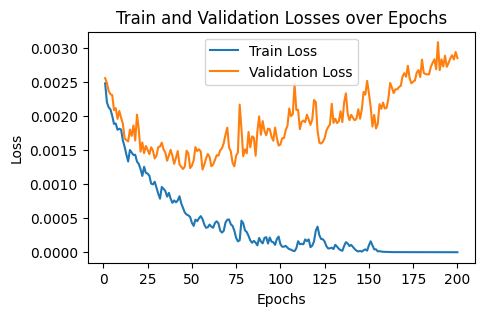

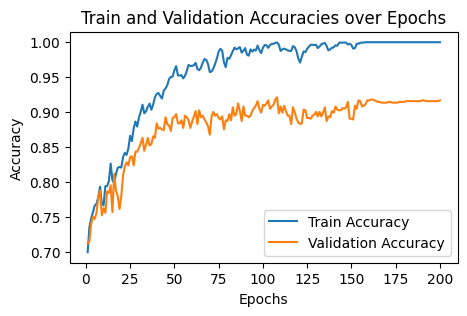

In [24]:
#Loss and accuracy plot
plot_losses(train_losses, valid_losses, config.EPOCH)
plot_accuracies(train_accuracies, valid_accuracies, config.EPOCH)

In [23]:
# 제일 성능이 좋은 모델 불러오기
model.load_state_dict(torch.load("/home/user/Desktop/bsh/absoluteA/model/3000_LSTM_best_model.pth"))
Macro_f1, auroc, accuracy, all_labels, all_probabilities = test(model, test_loader)
print(f"Best epoch: {best_epoch_save}")
print(f"macro F1 Score: {Macro_f1}")
print(f"AUROC: {auroc}")
print(f"Accuracy: {accuracy}")

100%|██████████| 4/4 [00:00<00:00, 388.03it/s]

Best epoch: 108
macro F1 Score: 0.8928597087617269
AUROC: 0.9272223595320481
Accuracy: 0.8982494529540481


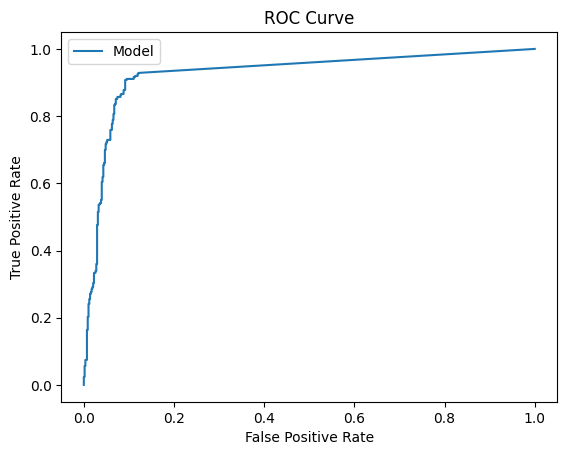

: 

In [26]:
# AUROC plot
plot_roc_curve(all_labels, all_probabilities)